In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [106]:
SMALL_SIZE = 10
MEDIUM_SIZE = 25
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)
plt.rc('axes', linewidth = 4.)

load data

In [72]:
n_rois = 68
count_offset = 100
data_path = '../sample_data/'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path+'hcp_data.npy')
n_subs = brain_networks.shape[0]

In [73]:
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

In [74]:
with open(data_path+'hcp_traits_dict.txt') as f:
    lines = f.readlines()
f.close()

In [75]:
pic_vocab = traits[:,6]
card_sort = traits[:,42]
oral_reading = traits[:,4]
pattern_complete = traits[:,10]
pic_seq = traits[:,37]

In [15]:
drop_ids = np.isnan(card_sort)
card_sort = card_sort[~drop_ids]
brain_networks = brain_networks[~drop_ids]
motion = motion[~drop_ids]
n_subs = brain_networks.shape[0]

In [76]:
config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .01, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=1e-5, device=DEVICE)

In [77]:
A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]

In [94]:
ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(oral_reading).to(torch.float32) 

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


vae

In [95]:
oral_reading_vae = VAE(config).to(config.device)
oral_reading_vae.apply(reset_weights)
oral_reading_vae.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_vae.parameters(), lr=config.lr) 

In [96]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_vae.reg_train(epoch, train_loader, oral_reading_vae, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_vae.reg_test(epoch, val_loader, oral_reading_vae, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 1454.429 nll: -7208.367 kl: 771.420 rmse: 16.365
epoch: 0 test loss: -10003.591 nll: -15311.670 kl: 2299.505 rmse: 13.786
epoch: 5 train loss: -16452.424 nll: -16911.783 kl: 16395.543 rmse: 3.021
epoch: 5 test loss: -16520.124 nll: -16924.159 kl: 16170.615 rmse: 2.852
epoch: 10 train loss: -16482.800 nll: -16924.857 kl: 15507.760 rmse: 2.978
epoch: 10 test loss: -16543.443 nll: -16933.505 kl: 15334.466 rmse: 2.815
epoch: 15 train loss: -16504.451 nll: -16930.620 kl: 15038.242 rmse: 2.920
epoch: 15 test loss: -16558.997 nll: -16937.485 kl: 14876.393 rmse: 2.770
epoch: 20 train loss: -16524.381 nll: -16934.648 kl: 14740.529 rmse: 2.851
epoch: 20 test loss: -16572.054 nll: -16940.048 kl: 14578.672 rmse: 2.721
epoch: 25 train loss: -16545.082 nll: -16939.602 kl: 14502.153 rmse: 2.778
epoch: 25 test loss: -16586.290 nll: -16944.705 kl: 14348.218 rmse: 2.675
epoch: 30 train loss: -16568.699 nll: -16948.111 kl: 14283.106 rmse: 2.706
epoch: 30 test loss: -16601.903 nll: -1

inv_vae

In [100]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = .01, gamma = .01, add_reg = True, y_dim = 1,
    batch_size=32, n_epochs=200, lr=2e-5, device=DEVICE)

In [101]:
oral_reading_inv = INV_VAE(config).to(config.device)
oral_reading_inv.apply(reset_weights)
oral_reading_inv.set_mask(knn_masks)
optimizer = optim.Adam(oral_reading_inv.parameters(), lr=config.lr) 

In [102]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = oral_reading_inv.reg_train(epoch, train_loader, oral_reading_inv, optimizer, config.device, n_epoch_display=5)
    val_loss = oral_reading_inv.reg_test(epoch, val_loader, oral_reading_inv, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 8715.630 nll: -7104.412 kl: 1255.305 inv_loss: 9.697 rmse: 16.498
epoch: 0 test loss 5316.565 nll: -15300.937 kl: 4935.784 inv_loss: 21.137 rmse: 14.026
epoch: 5 train loss: 122.787 nll: -16906.002 kl: 595516.182 inv_loss: 2.538 rmse: 3.002
epoch: 5 test loss 69.886 nll: -16918.319 kl: 529554.224 inv_loss: 1.799 rmse: 2.843
epoch: 10 train loss: 114.950 nll: -16924.666 kl: 234139.212 inv_loss: 1.721 rmse: 2.963
epoch: 10 test loss 64.662 nll: -16932.960 kl: 272608.808 inv_loss: 1.453 rmse: 2.809
epoch: 15 train loss: 105.163 nll: -16931.499 kl: 193827.455 inv_loss: 1.625 rmse: 2.912
epoch: 15 test loss 58.415 nll: -16940.299 kl: 205146.414 inv_loss: 1.480 rmse: 2.769
epoch: 20 train loss: 94.258 nll: -16935.867 kl: 161650.811 inv_loss: 1.474 rmse: 2.854
epoch: 20 test loss 51.918 nll: -16946.717 kl: 176908.343 inv_loss: 1.372 rmse: 2.728
epoch: 25 train loss: 82.925 nll: -16934.919 kl: 201842.185 inv_loss: 1.480 rmse: 2.792
epoch: 25 test loss 45.865 nll: -16946.29

plotting

In [103]:
n=39
x = 0.32 
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

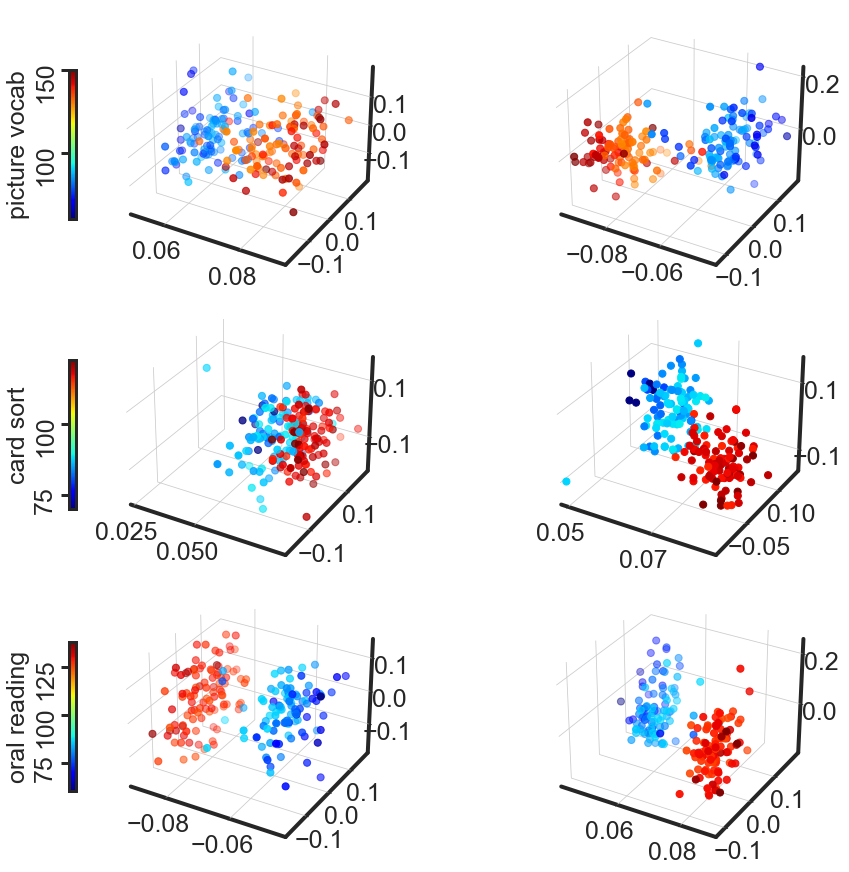

In [107]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12), constrained_layout=True, subplot_kw=dict(projection='3d'))
plt.style.use('seaborn-white')

################## pic vocab - vae ##################
# pic_vocab_vae_z_mean, _ = pic_vocab_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_vae_y_pred, _, _ = pic_vocab_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# pic_vocab_vae_y_pred = pic_vocab_vae_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_vae_z_mean_sub = pic_vocab_vae_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_vae_z_mean_sub.transpose())
# pic_vocab_vae_pcs = pca.components_.transpose()

p1 = axes[0,0].scatter(pic_vocab_vae_pcs[:,0], pic_vocab_vae_pcs[:,1], pic_vocab_vae_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
cb = fig.colorbar(p1, ax=axes[0,0], location='left', fraction=0.02, label='picture vocab')
axes[0,0].set_xlim3d(min(pic_vocab_vae_pcs[:,0]), max(pic_vocab_vae_pcs[:,0]))
axes[0,0].set_ylim3d(min(pic_vocab_vae_pcs[:,1]), max(pic_vocab_vae_pcs[:,1]))
axes[0,0].set_zlim3d(min(pic_vocab_vae_pcs[:,2]), max(pic_vocab_vae_pcs[:,2]))
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)

################## pic vocab - inv_vae ##################
# pic_vocab_inv_z_mean, _ = pic_vocab_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, pic_vocab_inv_y_pred, _, _ = pic_vocab_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# pic_vocab_inv_y_pred = pic_vocab_inv_y_pred.detach().cpu().numpy()

# pic_vocab_y_ids = np.argsort(pic_vocab)
# pic_vocab_y_sub_ids = np.concatenate([pic_vocab_y_ids[:100], pic_vocab_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# pic_vocab_vae_colors = pic_vocab[pic_vocab_y_sub_ids]

# pic_vocab_inv_z_mean_sub = pic_vocab_inv_z_mean[pic_vocab_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(pic_vocab_inv_z_mean_sub.transpose())
# pic_vocab_inv_pcs = pca.components_.transpose()

p2 = axes[0,1].scatter(pic_vocab_inv_pcs[:,0], pic_vocab_inv_pcs[:,1], pic_vocab_inv_pcs[:,2], c=pic_vocab_vae_colors, cmap = 'jet', s = 50, vmin=60, vmax=150)
# axes[0,1].set_title('inv-VAE')
axes[0,1].set_xlim3d(min(pic_vocab_inv_pcs[:,0]), max(pic_vocab_inv_pcs[:,0]))
axes[0,1].set_ylim3d(min(pic_vocab_inv_pcs[:,1]), max(pic_vocab_inv_pcs[:,1]))
axes[0,1].set_zlim3d(min(pic_vocab_inv_pcs[:,2]), max(pic_vocab_inv_pcs[:,2]))


################## card sort - vae ##################
# card_sort_vae_z_mean, _ = card_sort_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_vae_y_pred, _, _ = card_sort_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# card_sort_vae_y_pred = card_sort_vae_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_vae_z_mean_sub = card_sort_vae_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(card_sort_vae_z_mean_sub.transpose())
# card_sort_vae_pcs = pca.components_.transpose()

p3 = axes[1,0].scatter(card_sort_vae_pcs[:,0], card_sort_vae_pcs[:,1], card_sort_vae_pcs[:,2], 
                       c=card_sort_vae_colors, cmap = 'jet', s = 50, vmin=70)
cb = fig.colorbar(p3, ax=axes[1,0], location='left', fraction=0.02, label='card sort')
axes[1,0].set_xlim3d(min(card_sort_vae_pcs[:,0]), max(card_sort_vae_pcs[:,0]))
axes[1,0].set_ylim3d(min(card_sort_vae_pcs[:,1]), max(card_sort_vae_pcs[:,1]))
axes[1,0].set_zlim3d(min(card_sort_vae_pcs[:,2]), max(card_sort_vae_pcs[:,2]))
axes[1,0].set_xticks([0.025, 0.05])
axes[1,0].set_yticks([-0.1, 0.1])
axes[1,0].set_zticks([-0.1, 0.1])
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)

################## card sort - inv_vae ##################
# card_sort_inv_z_mean, _ = card_sort_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
# _, card_sort_inv_y_pred, _, _ = card_sort_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
#                                              tensor_motion.to(config.device))
# card_sort_inv_y_pred = card_sort_inv_y_pred.detach().cpu().numpy()

# card_sort_y_ids = np.argsort(card_sort)
# card_sort_y_sub_ids = np.concatenate([card_sort_y_ids[:100], card_sort_y_ids[-100:]])
# labels = np.concatenate([np.zeros(100), np.ones(100)])
# card_sort_vae_colors = card_sort[card_sort_y_sub_ids]

# card_sort_inv_z_mean_sub = card_sort_inv_z_mean[card_sort_y_sub_ids, :].detach().cpu().numpy()
# pca = PCA(n_components=3)
# pca.fit(card_sort_inv_z_mean_sub.transpose())
# card_sort_inv_pcs = pca.components_.transpose()

p4 = axes[1,1].scatter(card_sort_inv_pcs[:,0], card_sort_inv_pcs[:,1], card_sort_inv_pcs[:,2], c=card_sort_vae_colors, 
                       cmap = 'jet', s = 50, alpha=1., vmin=70)
axes[1,1].set_xlim3d(min(card_sort_inv_pcs[:,0]), max(card_sort_inv_pcs[:,0]))
axes[1,1].set_ylim3d(min(card_sort_inv_pcs[:,1]), max(card_sort_inv_pcs[:,1]))
axes[1,1].set_zlim3d(min(card_sort_inv_pcs[:,2]), max(card_sort_inv_pcs[:,2]))
axes[1,1].set_xticks([0.05, 0.07])
axes[1,1].set_yticks([-0.05, 0.1])
axes[1,1].set_zticks([-0.1, 0.1])

################## oral reading - vae ##################
oral_reading_vae_z_mean, _ = oral_reading_vae.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_vae_y_pred, _, _ = oral_reading_vae(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
oral_reading_vae_y_pred = oral_reading_vae_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_vae_z_mean_sub = oral_reading_vae_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_vae_z_mean_sub.transpose())
oral_reading_vae_pcs = pca.components_.transpose()

p5 = axes[2,0].scatter(oral_reading_vae_pcs[:,0], oral_reading_vae_pcs[:,1], oral_reading_vae_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
cb = plt.colorbar(p5, ax=axes[2,0], location='left', fraction=0.02, label='oral reading')
axes[2,0].set_xlim3d(min(oral_reading_vae_pcs[:,0]), max(oral_reading_vae_pcs[:,0]))
axes[2,0].set_ylim3d(min(oral_reading_vae_pcs[:,1]), max(oral_reading_vae_pcs[:,1]))
axes[2,0].set_zlim3d(min(oral_reading_vae_pcs[:,2]), max(oral_reading_vae_pcs[:,2]))
cb.outline.set_linewidth(3)
cb.ax.tick_params(labelrotation=90, length=8, width=3)


################## oral reading - inv_vae ##################
oral_reading_inv_z_mean, _ = oral_reading_inv.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
_, oral_reading_inv_y_pred, _, _ = oral_reading_inv(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                                             tensor_motion.to(config.device))
oral_reading_inv_y_pred = oral_reading_inv_y_pred.detach().cpu().numpy()

oral_reading_y_ids = np.argsort(oral_reading)
oral_reading_y_sub_ids = np.concatenate([oral_reading_y_ids[:100], oral_reading_y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
oral_reading_vae_colors = oral_reading[oral_reading_y_sub_ids]

oral_reading_inv_z_mean_sub = oral_reading_inv_z_mean[oral_reading_y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(oral_reading_inv_z_mean_sub.transpose())
oral_reading_inv_pcs = pca.components_.transpose()

p6 = axes[2,1].scatter(oral_reading_inv_pcs[:,0], oral_reading_inv_pcs[:,1], oral_reading_inv_pcs[:,2], c=oral_reading_vae_colors, cmap = 'jet', s = 50)
axes[2,1].set_xlim3d(min(oral_reading_inv_pcs[:,0]), max(oral_reading_inv_pcs[:,0]))
axes[2,1].set_ylim3d(min(oral_reading_inv_pcs[:,1]), max(oral_reading_inv_pcs[:,1]))
axes[2,1].set_zlim3d(min(oral_reading_inv_pcs[:,2]), max(oral_reading_inv_pcs[:,2]))

for i in range(3):
    for j in range(2):
        axes[i,j].xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        axes[i,j].zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        

plt.savefig('saved_figs/fig8_hcp_trait_latents.png', facecolor='white', dpi=400)
plt.show()